### Download the dataset
<b>Dataset location: </b>https://www.kaggle.com/c/3136/download/train.csv

In [1]:
import findspark
findspark.init()
findspark.find()

from IPython.display import *
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import pyspark
print(pyspark.__version__)

3.5.2


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Examine data about passengers on the Titanic') \
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('titanic.csv')

In [4]:
rawData.toPandas().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


#### Select the columns which we required
Also cast the numeric values as float

In [5]:
from pyspark.sql.functions import col

dataset = rawData.select(col('Survived').cast('float'),
                         col('Pclass').cast('float'),
                         col('Sex'),
                         col('Age').cast('float'),
                         col('Fare').cast('float'),
                         col('Embarked')
                        )

dataset.toPandas().head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0.0,3.0,male,22.0,7.250000,S
1,1.0,1.0,female,38.0,71.283302,C
2,1.0,3.0,female,26.0,7.925000,S
3,1.0,1.0,female,35.0,53.099998,S
4,0.0,3.0,male,35.0,8.050000,S


#### Drop rows containing missing values

In [6]:
dataset = dataset.replace('?', None)\
        .dropna(how='any')

#### Define StringIndexers for categorical columns

In [7]:
from pyspark.ml.feature import StringIndexer

dataset = StringIndexer(
    inputCol='Sex', 
    outputCol='Gender', 
    handleInvalid='keep').fit(dataset).transform(dataset)

dataset = StringIndexer(
    inputCol='Embarked', 
    outputCol='Boarded', 
    handleInvalid='keep').fit(dataset).transform(dataset)

dataset.toPandas().head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Gender,Boarded
0,0.0,3.0,male,22.0,7.250000,S,0.0,0.0
1,1.0,1.0,female,38.0,71.283302,C,1.0,1.0
2,1.0,3.0,female,26.0,7.925000,S,1.0,0.0
3,1.0,1.0,female,35.0,53.099998,S,1.0,0.0
4,0.0,3.0,male,35.0,8.050000,S,0.0,0.0


#### Drop the redundant columns

In [8]:
dataset = dataset.drop('Sex')
dataset = dataset.drop('Embarked')

dataset.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded
0,0.0,3.0,22.0,7.250000,0.0,0.0
1,1.0,1.0,38.0,71.283302,1.0,1.0
2,1.0,3.0,26.0,7.925000,1.0,0.0
3,1.0,1.0,35.0,53.099998,1.0,0.0
4,0.0,3.0,35.0,8.050000,0.0,0.0


#### Define the required features to use in the VectorAssembler
Since we are only examining data and not making predictions, we include all columns

In [9]:
requiredFeatures = ['Survived',
                    'Pclass',
                    'Age',
                    'Fare',
                    'Gender',
                    'Boarded'
                   ]

#### The VectorAssembler vectorises all the features
The transformed data will be used for clustering

In [10]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

#### Transorm our dataset for use in our clustering algorithm

In [11]:
transformed_data = assembler.transform(dataset)

In [12]:
transformed_data.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded,features
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]"
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]"
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]"
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]"
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[0.0, 3.0, 35.0, 8.050000190734863, 0.0, 0.0]"


### Define the clustering model
Use K-means clustering
* <b>k: </b>Defines the number of clusters
* <b>seed: </b>This value is used to set the cluster centers. A different value of seed for the same k will result in clusters being defined differently. In order to reproduce similar clusters when re-running the clustering algorithm use the same values of k and seed

In [13]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5, seed=3)
model = kmeans.fit(transformed_data)

#### Create the clusters using the model

In [14]:
clusterdData = model.transform(transformed_data)

#### Use ClusteringEvaluator to evaluate the clusters
<b>From Wikipedia: </b>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [15]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusterdData)
print('Silhouette with squared euclidean distance = ', silhouette)

Silhouette with squared euclidean distance =  0.5575950682280559


#### View the cluster centers for each of the features

In [16]:
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

Cluster Centers: 
[ 0.28877005  2.16042781 44.48395722 18.63937112  0.26203209  0.18181818]
[ 0.35233161  2.6865285  20.67810881 14.94750579  0.34974093  0.2357513 ]
[  0.77777778   1.          30.55555556 345.97085232   0.55555556
   0.55555556]
[  0.76         1.          33.1968     175.02082581   0.76
   0.44      ]
[ 0.68571429  1.14285714 35.23809524 74.92690575  0.48571429  0.42857143]


#### View the output of the KMeans model
The prediction field denotes the cluster number

In [17]:
clusterdData.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded,features,prediction
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]",1
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]",4
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]",1
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]",4
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[0.0, 3.0, 35.0, 8.050000190734863, 0.0, 0.0]",0


#### Get the average of each feature in the original data
This is the equivalent of the cluster center when our dataset is one big cluster
* We import all sql functions as we need the avg and count functions among others

In [18]:
from pyspark.sql.functions import *

dataset.select(avg('Survived'),
               avg('Pclass'),
               avg('Age'),
               avg('Fare'),
               avg('Gender'),
               avg('Boarded')).toPandas()

,avg(Survived),avg(Pclass),avg(Age),avg(Fare),avg(Gender),avg(Boarded)
0,0.404494,2.240169,29.642093,34.567251,0.363764,0.261236


#### A more intuitive way to view the cluster centers in our clusterdData
* We group by clusterID (prediction) and compute the average of all features
* We do a count of values in each cluster

In [19]:
clusterdData.groupBy('prediction').agg(avg('Survived'),
                                      avg('Pclass'),
                                      avg('Age'),
                                      avg('Fare'),
                                      avg('Gender'),
                                      avg('Boarded'),
                                      count('prediction')
                                     ).orderBy('prediction').toPandas()

,prediction,avg(Survived),avg(Pclass),avg(Age),avg(Fare),avg(Gender),avg(Boarded),count(prediction)
0,0,0.288770,2.160428,44.483957,18.639371,0.262032,0.181818,187
1,1,0.352332,2.686528,20.678109,14.947506,0.349741,0.235751,386
2,2,0.777778,1.000000,30.555556,345.970852,0.555556,0.555556,9
3,3,0.760000,1.000000,33.196800,175.020826,0.760000,0.440000,25
4,4,0.685714,1.142857,35.238095,74.926906,0.485714,0.428571,105


#### Examine all rows in one of the clusters

In [20]:
clusterdData.filter(clusterdData.prediction == 1).toPandas()

,Survived,Pclass,Age,Fare,Gender,Boarded,features,prediction
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]",1
1,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]",1
2,0.0,3.0,2.0,21.075001,0.0,0.0,"[0.0, 3.0, 2.0, 21.075000762939453, 0.0, 0.0]",1
3,1.0,3.0,27.0,11.133300,1.0,0.0,"[1.0, 3.0, 27.0, 11.133299827575684, 1.0, 0.0]",1
4,1.0,2.0,14.0,30.070801,1.0,1.0,"[1.0, 2.0, 14.0, 30.07080078125, 1.0, 1.0]",1
...,...,...,...,...,...,...,...,...
381,0.0,3.0,25.0,7.050000,0.0,0.0,"[0.0, 3.0, 25.0, 7.050000190734863, 0.0, 0.0]",1
382,0.0,2.0,27.0,13.000000,0.0,0.0,"[0.0, 2.0, 27.0, 13.0, 0.0, 0.0]",1
383,1.0,1.0,19.0,30.000000,1.0,0.0,"[1.0, 1.0, 19.0, 30.0, 1.0, 0.0]",1
384,1.0,1.0,26.0,30.000000,0.0,1.0,"[1.0, 1.0, 26.0, 30.0, 0.0, 1.0]",1


Silhouette Score for k=2: 0.9077791310613383
Silhouette Score for k=3: 0.846706210108751
Silhouette Score for k=4: 0.7752371406213503
Silhouette Score for k=5: 0.5575950682280559
Silhouette Score for k=6: 0.5814750685515234
Silhouette Score for k=7: 0.5829149020249024
Silhouette Score for k=8: 0.6314387412353603
Silhouette Score for k=9: 0.5937000445036649
Silhouette Score for k=10: 0.6292829322582175


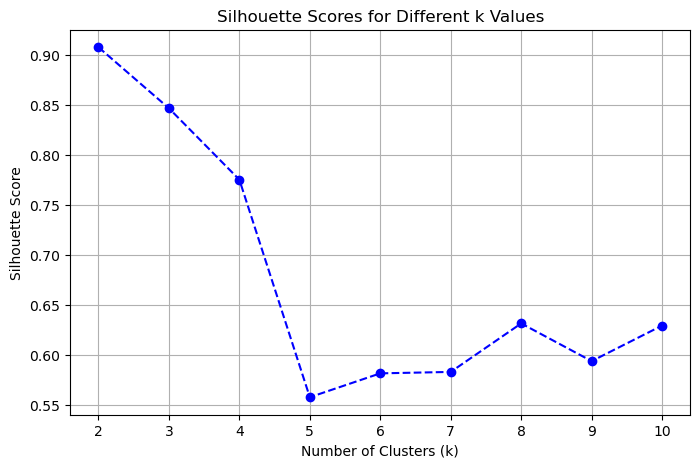

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialize list to store the silhouette scores
silhouette_scores = []

# Range of k values to test
k_values = range(2, 11)

for k in k_values:
    # Define the KMeans model
    kmeans = KMeans(k=k, seed=3)
    model = kmeans.fit(transformed_data)
    
    # Evaluate the clusters using silhouette score
    clusterdData = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(clusterdData)
    
    # Append silhouette score
    silhouette_scores.append(silhouette)
    print(f"Silhouette Score for k={k}: {silhouette}")

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()
